In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

In [4]:
include("utils.jl")
using Revise
using .Utils

In [5]:
dtype = Float64

Float64

Step 1: definire questa matrice
$$\Sigma^{AB}_{ij}(\ell)= \sqrt{\frac{2}{(2\ell+1)\Delta \ell f_{sky}}}\left[ C_{ij}^{AB}(\ell)+N^{AB}_{ij}(\ell)\right]$$
Step 2: mettere i $C_\ell$ in una matrice a blocchi
Step 3: $$\Delta \chi^2 = \sum_{\ell} Tr{(\Sigma(\ell)^{-1}\Delta C_\ell)^2}$$

Voglio reinterpolare tutti i $C_\ell$ su una griglia equispaziata con $\Delta \ell = 1$

#### Interpolating N5K stuff

In [6]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [7]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
Pknonlin = pk_dict["pk_nl"]
k = pk_dict["k"]
z = pk_dict["z"];

In [8]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [9]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm_nl = Interpolations.interpolate(log10.(Pknonlin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, x, y)
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line());

In [10]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [11]:
power_spectrum_nl(k, χ1, χ2) = @. sqrt(10^InterpPmm_nl(z_of_χ(χ1),log10(k)) * 10^InterpPmm_nl(z_of_χ(χ2),log10(k)));

#### Loading N5K stuff

In [12]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [13]:
gg = dtype.(benchmark_gg["cls"])
ll = dtype.(benchmark_ll["cls"])
gl = dtype.(benchmark_gl["cls"])
ell = dtype.(benchmark_gg["ls"]);

In [14]:
gg_reshaped = zeros( dtype, length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [15]:
ll_reshaped = zeros(dtype, length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [16]:
gl_reshaped = zeros( dtype, length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in 1:5
        gl_reshaped[:,i,j] = gl[counter, :]
        counter += 1
    end
end

#### Load $\tilde T$ and interpolate everything!

In [46]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 115
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
nχ = 96
χ = LinRange(26, 7000, nχ)
ℓ = dtype.(npzread("ell_vector.npy")[1:21])
ℓ_final = 2:1:200;

In [47]:
gg_interp = zeros(dtype, 199,10,10)
ll_interp = zeros(dtype, 199,5,5)
gl_interp = zeros(dtype, 199,10,5)

for i in 1:10
    for j in i:10
        interpol = AkimaInterpolation(gg_reshaped[:,i,j], ell)
        gg_interp[:,i,j] = interpol.(ℓ_final)
        gg_interp[:,j,i] = gg_interp[:,i,j]
    end
end

for i in 1:5
    for j in i:5
        interpol = AkimaInterpolation(ll_reshaped[:,i,j], ell)
        ll_interp[:,i,j] = interpol.(ℓ_final)
        ll_interp[:,j,i] = ll_interp[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = AkimaInterpolation(gl_reshaped[:,i,j], ell)
        gl_interp[:,i,j] = interpol.(ℓ_final)
    end
end

#### 75+175, $\alpha = 0.85$

In [67]:
R = unique(vcat(LinRange(0,0.85,76)[2:end], LinRange(0.85,1,176)))
nR = length(R)
coeff = zeros(nχ,nR,n_cheb+1)

for i in 1:nR 
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R[i]), log10(kmin), log10(kmax)); 
        coeff[j,i,:] = c.coefs
    end
end

In [68]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+175", nχ, nR)[:,:,:,1:n_cheb+1]
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+175", nχ, nR)[:,:,:,1:n_cheb+1]
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+175", nχ, nR)[:,:,:,1:n_cheb+1]


w_LL = dtype.(Will.w_ell_tullio(coeff, T_LL))
w_CL = dtype.(Will.w_ell_tullio(coeff, T_CL))
w_CC = dtype.(Will.w_ell_tullio(coeff, T_CC));

#### Finally, compute $C_\ell$'s

In [69]:
Cℓ_CC_limb = dtype.(npzread("Cl_CC_limber_linear.npy"))
Cℓ_CL_limb =  dtype.(npzread("Cl_CL_limber_linear.npy"))
Cℓ_LL_limb =  dtype.(npzread("Cl_LL_limber_linear.npy"));

In [70]:
Cℓ_CC_limb_nl = dtype.(npzread("Cl_CC_limber_nl.npy"))
Cℓ_CL_limb_nl = dtype.(npzread("Cl_CL_limber_nl.npy"))
Cℓ_LL_limb_nl = dtype.(npzread("Cl_LL_limber_nl.npy"));

In [71]:
W = npzread("../N5K/input/kernels_fullwidth.npz")
@time K_CC, K_CL, K_LL = compute_kernels(W, χ, R);

  0.031077 seconds (787 allocations: 47.205 MiB)


In [72]:
K_CC, K_CL, K_LL =  dtype.(K_CC), dtype.(K_CL),dtype.( K_LL );

In [75]:
Cℓ_CC = dtype.(C_ell_computation_simpson_uneven_grid(w_CC, K_CC, χ, 75, 175, 0.85))
Cℓ_CL = dtype.(C_ell_computation_simpson_uneven_grid(w_CL, K_CL, χ, 75, 175, 0.85))
Cℓ_LL = dtype.(C_ell_computation_simpson_uneven_grid(w_LL, K_LL, χ, 75, 175, 0.85));

In [76]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* dtype(2/π)

for i in 1:length(ℓ)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* dtype(factorial_frac(ℓ[i]) ./ π)
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* dtype(sqrt.(factorial_frac(ℓ[i])) ./ π)
end

In [77]:
final_Cℓ_CC = Cℓ_CC + Cℓ_CC_limb_nl - Cℓ_CC_limb
final_Cℓ_CL = Cℓ_CL + Cℓ_CL_limb_nl - Cℓ_CL_limb
final_Cℓ_LL = Cℓ_LL + Cℓ_LL_limb_nl - Cℓ_LL_limb;

##### Adding the Limber $C_\ell$'s after 300

In [78]:
Cℓ_CC_limb = dtype.(npzread("Cl_CC_limber.npy"))
Cℓ_CL_limb = dtype.(npzread("Cl_CL_limber.npy"))
Cℓ_LL_limb = dtype.(npzread("Cl_LL_limber.npy"));

In [79]:
total_Cℓ_CC = cat(final_Cℓ_CC, Cℓ_CC_limb, dims=1)
total_Cℓ_CL = cat(final_Cℓ_CL, Cℓ_CL_limb, dims=1)
total_Cℓ_LL = cat(final_Cℓ_LL, Cℓ_LL_limb, dims=1);

##### And interpolating them on the same $\ell$ grid

In [80]:
elle = dtype.(reverse(chebpoints(100, 2, 3000)))
ℓ_min = 2
ℓ_max = 3000

interp_Cℓ_CC = zeros(dtype, length(ℓ_final), 10, 10)
interp_Cℓ_CL = zeros(dtype, length(ℓ_final), 10, 5)
interp_Cℓ_LL = zeros(dtype, length(ℓ_final), 5, 5)

for i in 1:10
    for j in i:10
        interpol = chebinterp(reverse(total_Cℓ_CC[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
        interp_Cℓ_CC[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
        interp_Cℓ_CC[:,j,i] = interp_Cℓ_CC[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = chebinterp(reverse(total_Cℓ_CL[:,i,j].*elle.*elle),ℓ_min, ℓ_max)
        interp_Cℓ_CL[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
    end
end

for i in 1:5
    for j in i:5
        interpol = chebinterp(reverse(total_Cℓ_LL[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
        interp_Cℓ_LL[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
        interp_Cℓ_LL[:,j,i] = interp_Cℓ_LL[:,i,j]
    end
end

# Block matrix

In [81]:
Cℓ_matrix = zeros(dtype, length(ℓ_final), 15, 15)
CC = interp_Cℓ_CC
CL = interp_Cℓ_CL
LL = interp_Cℓ_LL

Cℓ_matrix[:,1:5,1:5] = LL
Cℓ_matrix[:,6:15,6:15] = CC
Cℓ_matrix[:, 1:5, 6:15] = permutedims(CL, (1,3,2))
Cℓ_matrix[:, 6:15, 1:5] = CL;

In [82]:
Cℓ_N5K = zeros(dtype, length(ℓ_final), 15, 15)

Cℓ_N5K[:,1:5,1:5] = ll_interp
Cℓ_N5K[:,6:15,6:15] = gg_interp
Cℓ_N5K[:, 1:5, 6:15] = permutedims(gl_interp, (1,3,2))
Cℓ_N5K[:, 6:15, 1:5] = gl_interp;

In [83]:
ΔC = Cℓ_matrix .- Cℓ_N5K;

In [84]:
@time Σ_CC, Σ_LL, Σ_CL =  Σ(gg_interp, ll_interp, gl_interp, ℓ_final,dtype,0.4);

  0.000244 seconds (31 allocations: 545.422 KiB)


In [85]:
Σ_matrix = zeros(dtype, 199, 15, 15)

Σ_matrix[:,1:5,1:5] = Σ_LL
Σ_matrix[:,6:15,6:15] = Σ_CC
Σ_matrix[:, 1:5, 6:15] = permutedims(Σ_CL, (1,3,2))
Σ_matrix[:, 6:15, 1:5] = Σ_CL;

In [86]:
Σ_inv = zeros(dtype, 199, 15, 15)

for l in 1:199
    Σ_inv[l,:,:] = inv(Σ_matrix[l,:,:])
end

In [87]:
@tullio Δχ2 := Σ_inv[l,i,j] * ΔC[l,j,k] * Σ_inv[l,k,m] * ΔC[l,m,i]

0.3101101269261094

In [42]:
Δχ2_prog = Δχ²_vec(ΔC, Σ_inv, dtype);

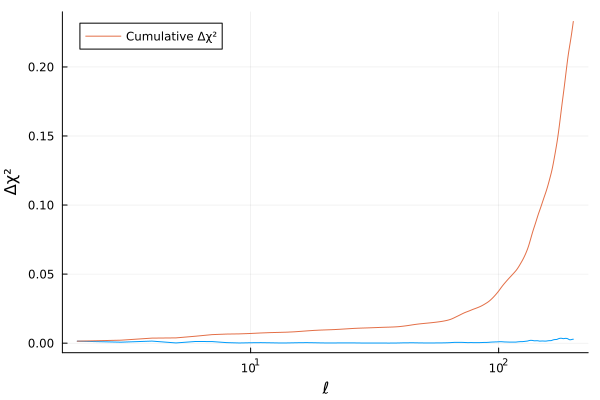

In [43]:
plot(ℓ_final, Δχ2_prog, label=nothing, xlabel="ℓ", ylabel="Δχ²", xscale=:log10)
plot!(ℓ_final, cumsum(Δχ2_prog), label="Cumulative Δχ²")

# Δχ² as a function of the number of cheb points

In [38]:
function make_ws(n_cheb, dtype)
    w_LL = Will.w_ell_tullio(coeff[:,:,1:n_cheb], T_LL[:,:,:,1:n_cheb])
    w_CL = Will.w_ell_tullio(coeff[:,:,1:n_cheb], T_CL[:,:,:,1:n_cheb])
    w_CC = Will.w_ell_tullio(coeff[:,:,1:n_cheb], T_CC[:,:,:,1:n_cheb]);
    return dtype.(w_CC),  dtype.(w_CL),  dtype.(w_LL)
end;

In [41]:
function calc_deltachi(n_cheb, dtype)
    w_CC, w_CL, w_LL = make_ws(n_cheb, dtype)

    W = npzread("../N5K/input/kernels_fullwidth.npz")
    K_CC, K_CL, K_LL = compute_kernels(W, χ, R)
    K_CC, K_CL, K_LL =  dtype.(K_CC), dtype.(K_CL),dtype.( K_LL )

    Cℓ_CC = dtype.(C_ell_computation_simpson_uneven_grid(w_CC, K_CC, χ, 75, 175, 0.85))
    Cℓ_CL = dtype.(C_ell_computation_simpson_uneven_grid(w_CL, K_CL, χ, 75, 175, 0.85))
    Cℓ_LL = dtype.(C_ell_computation_simpson_uneven_grid(w_LL, K_LL, χ, 75, 175, 0.85))

    # ADDING ELL PREFACTORS
    Cℓ_CC = Cℓ_CC .* dtype(2/π)

    for i in 1:length(ℓ)
        Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* dtype(factorial_frac(ℓ[i]) ./ π)
        Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* dtype(sqrt.(factorial_frac(ℓ[i])) ./ π)
    end

    Cℓ_CC_limb = dtype.(npzread("Cl_CC_limber_linear.npy"))
    Cℓ_CL_limb = dtype.(npzread("Cl_CL_limber_linear.npy"))
    Cℓ_LL_limb = dtype.(npzread("Cl_LL_limber_linear.npy"))

    Cℓ_CC_limb_nl = dtype.(npzread("Cl_CC_limber_nl.npy"))
    Cℓ_CL_limb_nl = dtype.(npzread("Cl_CL_limber_nl.npy"))
    Cℓ_LL_limb_nl = dtype.(npzread("Cl_LL_limber_nl.npy"))

    final_Cℓ_CC = Cℓ_CC + Cℓ_CC_limb_nl - Cℓ_CC_limb
    final_Cℓ_CL = Cℓ_CL + Cℓ_CL_limb_nl - Cℓ_CL_limb
    final_Cℓ_LL = Cℓ_LL + Cℓ_LL_limb_nl - Cℓ_LL_limb

    Cℓ_CC_limb = dtype.(npzread("Cl_CC_limber.npy"))
    Cℓ_CL_limb = dtype.(npzread("Cl_CL_limber.npy"))
    Cℓ_LL_limb = dtype.(npzread("Cl_LL_limber.npy"))

    total_Cℓ_CC = cat(final_Cℓ_CC, Cℓ_CC_limb, dims=1)
    total_Cℓ_CL = cat(final_Cℓ_CL, Cℓ_CL_limb, dims=1)
    total_Cℓ_LL = cat(final_Cℓ_LL, Cℓ_LL_limb, dims=1)

    elle = dtype.(reverse(chebpoints(100, 2, 3000)))
    ℓ_min = 2
    ℓ_max = 3000
    
    interp_Cℓ_CC = zeros(dtype, length(ℓ_final), 10, 10)
    interp_Cℓ_CL = zeros(dtype, length(ℓ_final), 10, 5)
    interp_Cℓ_LL = zeros(dtype, length(ℓ_final), 5, 5)
    
    for i in 1:10
        for j in i:10
            interpol = chebinterp(reverse(total_Cℓ_CC[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
            interp_Cℓ_CC[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
            interp_Cℓ_CC[:,j,i] = interp_Cℓ_CC[:,i,j]
        end
    end
    
    for i in 1:10
        for j in 1:5
            interpol = chebinterp(reverse(total_Cℓ_CL[:,i,j].*elle.*elle),ℓ_min, ℓ_max)
            interp_Cℓ_CL[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
        end
    end
    
    for i in 1:5
        for j in i:5
            interpol = chebinterp(reverse(total_Cℓ_LL[:,i,j].*elle.*elle), ℓ_min, ℓ_max)
            interp_Cℓ_LL[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
            interp_Cℓ_LL[:,j,i] = interp_Cℓ_LL[:,i,j]
        end
    end

    Cℓ_matrix = zeros(dtype, length(ℓ_final), 15, 15)
    
    Cℓ_matrix[:,1:5,1:5] = interp_Cℓ_LL
    Cℓ_matrix[:,6:15,6:15] = interp_Cℓ_CC
    Cℓ_matrix[:, 1:5, 6:15] = permutedims(interp_Cℓ_CL, (1,3,2))
    Cℓ_matrix[:, 6:15, 1:5] = interp_Cℓ_CL;

    Cℓ_N5K = zeros(dtype, length(ℓ_final), 15, 15)
    
    Cℓ_N5K[:,1:5,1:5] = ll_interp
    Cℓ_N5K[:,6:15,6:15] = gg_interp
    Cℓ_N5K[:, 1:5, 6:15] = permutedims(gl_interp, (1,3,2))
    Cℓ_N5K[:, 6:15, 1:5] = gl_interp

    ΔC = Cℓ_matrix .- Cℓ_N5K

    Σ_CC, Σ_LL, Σ_CL =  Σ(gg_interp, ll_interp, gl_interp, ℓ_final,dtype,0.4)

    @tullio Δχ2 := Σ_inv[l,i,j] * ΔC[l,j,k] * Σ_inv[l,k,m] * ΔC[l,m,i]

    return Δχ2
end

calc_deltachi (generic function with 1 method)

In [42]:
chi_vs_cheb = zeros(dtype, 129)
for n in 1:129
    println("Processing n = $n...")
    chi_vs_cheb[n] = calc_deltachi(n,dtype)
end
    

Processing n = 1...
Processing n = 2...
Processing n = 3...
Processing n = 4...
Processing n = 5...
Processing n = 6...
Processing n = 7...
Processing n = 8...
Processing n = 9...
Processing n = 10...
Processing n = 11...
Processing n = 12...
Processing n = 13...
Processing n = 14...
Processing n = 15...
Processing n = 16...
Processing n = 17...
Processing n = 18...
Processing n = 19...
Processing n = 20...
Processing n = 21...
Processing n = 22...
Processing n = 23...
Processing n = 24...
Processing n = 25...
Processing n = 26...
Processing n = 27...
Processing n = 28...
Processing n = 29...
Processing n = 30...
Processing n = 31...
Processing n = 32...
Processing n = 33...
Processing n = 34...
Processing n = 35...
Processing n = 36...
Processing n = 37...
Processing n = 38...
Processing n = 39...
Processing n = 40...
Processing n = 41...
Processing n = 42...
Processing n = 43...
Processing n = 44...
Processing n = 45...
Processing n = 46...
Processing n = 47...
Processing n = 48...
P

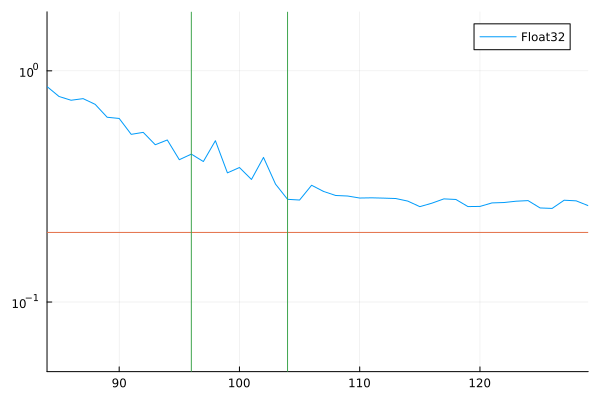

In [43]:
plot(1:129, chi_vs_cheb, label = dtype, yscale=:log10, xlim=(84,129), ylim=(0.05,1.8))
hline!([0.2],label=nothing)
vline!([96,104],label=nothing)

    n_cheb = 104 is the final choice for the N5K requirements!!

## Heatmap NR₂-α

The idea here is to take the big object (75+450, α=0.8) and interpolate it varying α and the number of points. For every configuration, compute Δχ². 

In [45]:
α_array = LinRange(0.8, 0.9, 11)
NR2_array = LinRange(150, 450, 7);

In [46]:
function Cℓ_interpolator(w, K, α, NR2, tracers)
    Δχ = ((last(χ)-first(χ))/(nχ-1))
    pesi_χ = SimpsonWeightArray(nχ)

    @tullio C̃[l,i,j,m] := χ[n]*K[i,j,n,m]*w[l,n,m]*pesi_χ[n]*Δχ

    #interpolate object on the R grid i want
    n1 = 75
    n2 = Int(NR2)
    R1 = LinRange(0,α,n1+1)[2:end]
    R2 = LinRange(α,1,n2+1)[2:end]
    R_interp = unique(vcat(R1, R2))

    C̃_interp = zeros(21, length(K[:,1,1,1]), length(K[1,:,1,1]), length(R_interp))
    for l in 1:21
        for i in 1:length(K[:,1,1,1])
            for j in 1:length(K[1,:,1,1])
                int = AkimaInterpolation(C̃[l,i,j,:], R)
                C̃_interp[l,i,j,:] = int.(R_interp)
            end
        end
    end

    #Now, finally do the R integration
    ΔR1 = dtype((last(R1)-first(R1))/(length(R1)-1))
    ΔR2 = dtype((last(R2)-first(R2))/(length(R2)-1))

    pesi_R = Composed_Simpson_Weights(n1, n2+1, ΔR1, ΔR2, dtype)
    
    @tullio Cℓ_interpolated[l,i,j] := C̃_interp[l,i,j,m]*pesi_R[m]

    #add prefactors
    if tracers == "CC"
        Cℓ_interpolated = Cℓ_interpolated .* (2/π)
    elseif tracers == "CL"
        for i in 1:length(ℓ)
            Cℓ_interpolated[i,:,:] = Cℓ_interpolated[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
        end
    elseif tracers == "LL"
        for i in 1:length(ℓ)
            Cℓ_interpolated[i,:,:] = Cℓ_interpolated[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
        end
    end

    Cℓ_limb = dtype.(npzread("Cl_$(tracers)_limber_linear.npy"))
    Cℓ_limb_nl = dtype.(npzread("Cl_$(tracers)_limber_nl.npy"))

    final_Cℓ = Cℓ_interpolated + Cℓ_limb_nl - Cℓ_limb

    #add chebpoints after l = 300 so i can interpolate with chebyshev
    Cℓ_limb_full = dtype.(npzread("Cl_$(tracers)_limber.npy"))

    total_Cℓ = cat(final_Cℓ, Cℓ_limb_full, dims=1)

    elle = dtype.(reverse(chebpoints(100, 2, 3000)))
    ℓ_min = 2
    ℓ_max = 3000
    
    interp_Cℓ = zeros(dtype, length(ℓ_final), length(K[:,1,1,1]), length(K[1,:,1,1]))

    for i in 1:length(K[:,1,1,1])
        for j in 1:length(K[1,:,1,1])
            interpol = chebinterp(reverse(total_Cℓ[:,i,j].*elle.*elle),ℓ_min, ℓ_max)
            interp_Cℓ[:,i,j] = interpol.(ℓ_final) ./ (ℓ_final.*ℓ_final)
        end
    end

    return interp_Cℓ
end

Cℓ_interpolator (generic function with 1 method)

In [47]:
function chi_square_tuning(α, NR2)

    w_CC, w_CL, w_LL = make_ws(104, dtype)

    W = npzread("../N5K/input/kernels_fullwidth.npz")
    K_CC, K_CL, K_LL = compute_kernels(W, χ, R)
    K_CC, K_CL, K_LL =  dtype.(K_CC), dtype.(K_CL),dtype.( K_LL )
    
    CC = Cℓ_interpolator(w_CC, K_CC, α, NR2, "CC")
    CL = Cℓ_interpolator(w_CL, K_CL, α, NR2, "CL")
    LL = Cℓ_interpolator(w_LL, K_LL, α, NR2, "LL")

    Cℓ_matrix = zeros(dtype, length(ℓ_final), 15, 15)
    
    Cℓ_matrix[:,1:5,1:5] = LL
    Cℓ_matrix[:,6:15,6:15] = CC
    Cℓ_matrix[:, 1:5, 6:15] = permutedims(CL, (1,3,2))
    Cℓ_matrix[:, 6:15, 1:5] = CL;

    Cℓ_N5K = zeros(dtype, length(ℓ_final), 15, 15)
    
    Cℓ_N5K[:,1:5,1:5] = ll_interp
    Cℓ_N5K[:,6:15,6:15] = gg_interp
    Cℓ_N5K[:, 1:5, 6:15] = permutedims(gl_interp, (1,3,2))
    Cℓ_N5K[:, 6:15, 1:5] = gl_interp

    ΔC = Cℓ_matrix .- Cℓ_N5K

    @tullio Δχ2 := Σ_inv[l,i,j] * ΔC[l,j,k] * Σ_inv[l,k,m] * ΔC[l,m,i]

    return Δχ2
end

chi_square_tuning (generic function with 1 method)

In [54]:
chi_squares = zeros(length(α_array), length(NR2_array))
for (aidx,a) in enumerate(α_array)
    println("Processing α = $a ...")
    for (nidx,n) in enumerate(NR2_array)
        app = chi_square_tuning(a, n)
        if app < 0.2
            chi_squares[aidx, nidx] = app
        else
            chi_squares[aidx, nidx] = 0
        end
    end
end

Processing α = 0.8 ...
Processing α = 0.81 ...
Processing α = 0.8200000000000002 ...
Processing α = 0.83 ...
Processing α = 0.8400000000000001 ...
Processing α = 0.8500000000000001 ...
Processing α = 0.8600000000000001 ...
Processing α = 0.8700000000000001 ...
Processing α = 0.8800000000000001 ...
Processing α = 0.89 ...
Processing α = 0.9 ...


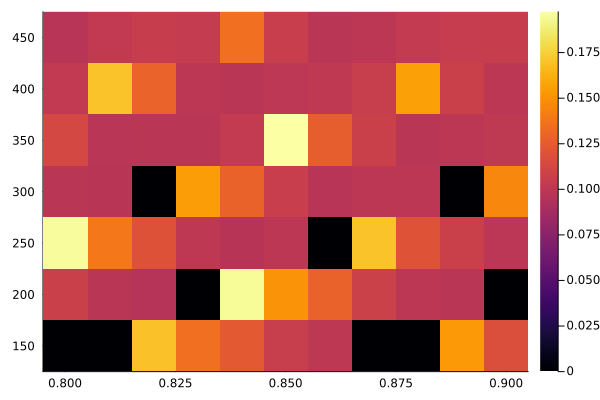

In [55]:
heatmap(α_array, NR2_array, chi_squares)

    α=0.85, NR2=150